# Email spam detection

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [16]:
df = pd.read_csv('/content/spam.csv', encoding = 'Latin')

In [11]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [14]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [17]:
df = df[['v1', 'v2']]

df.columns = ['label', 'message']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [18]:
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

df['label'].value_counts()

,count
label,
0,4825
1,747


In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_message'] = df['message'].apply(preprocess_text)


In [23]:
df[['message', 'clean_message']].head()

,message,clean_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [25]:
from sklearn.feature_extraction.text import CountVectorizer


In [26]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean_message'])

X.shape

(5572, 8467)

# Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(4457, 8467) (1115, 8467)


# Models

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC



In [33]:
models = {
    "NaiveBayes" : MultinomialNB().fit(X_train, y_train),
    "Logistic Regression" : LogisticRegression(max_iter=1000).fit(X_train, y_train),
    "SVC" : SVC(kernel='linear').fit(X_train, y_train)
}

In [35]:
from sklearn.metrics import classification_report


In [36]:
comparison_data = []

for name, model in models.items():


    y_pred = model.predict(X_test)
    y_pred_tr = model.predict(X_train)

    # Classification report'u al
    report_test = classification_report(y_test, y_pred, output_dict=True)
    report_train = classification_report(y_train, y_pred_tr, output_dict=True)


    for label in report_test.keys():
        if label not in ["accuracy", "macro avg", "weighted avg"]:
            comparison_data.append({
                'Model': name,
                'DataSet': 'Test',
                'Label': label,
                'Precision': report_test[label]['precision'],
                'Recall': report_test[label]['recall'],
                'F1-Score': report_test[label]['f1-score'],
                'Accuracy': report_test['accuracy']
            })
            comparison_data.append({
                'Model': name,
                'DataSet': 'Train',
                'Label': label,
                'Precision': report_train[label]['precision'],
                'Recall': report_train[label]['recall'],
                'F1-Score': report_train[label]['f1-score'],
                'Accuracy': report_train['accuracy']
            })


comparison_df = pd.DataFrame(comparison_data)

comparison_df

,Model,DataSet,Label,Precision,Recall,F1-Score,Accuracy
0,NaiveBayes,Test,0,0.984359,0.978238,0.981289,0.967713
1,NaiveBayes,Train,0,0.995339,0.995855,0.995597,0.992372
2,NaiveBayes,Test,1,0.865385,0.900000,0.882353,0.967713
3,NaiveBayes,Train,1,0.973109,0.969849,0.971477,0.992372
4,Logistic Regression,Test,0,0.973764,1.000000,0.986708,0.976682
5,Logistic Regression,Train,0,0.994588,0.999741,0.997158,0.995064
6,Logistic Regression,Test,1,1.000000,0.826667,0.905109,0.976682
7,Logistic Regression,Train,1,0.998267,0.964824,0.981261,0.995064
8,SVC,Test,0,0.973631,0.994819,0.984111,0.972197
9,SVC,Train,0,0.999741,1.000000,0.999870,0.999776


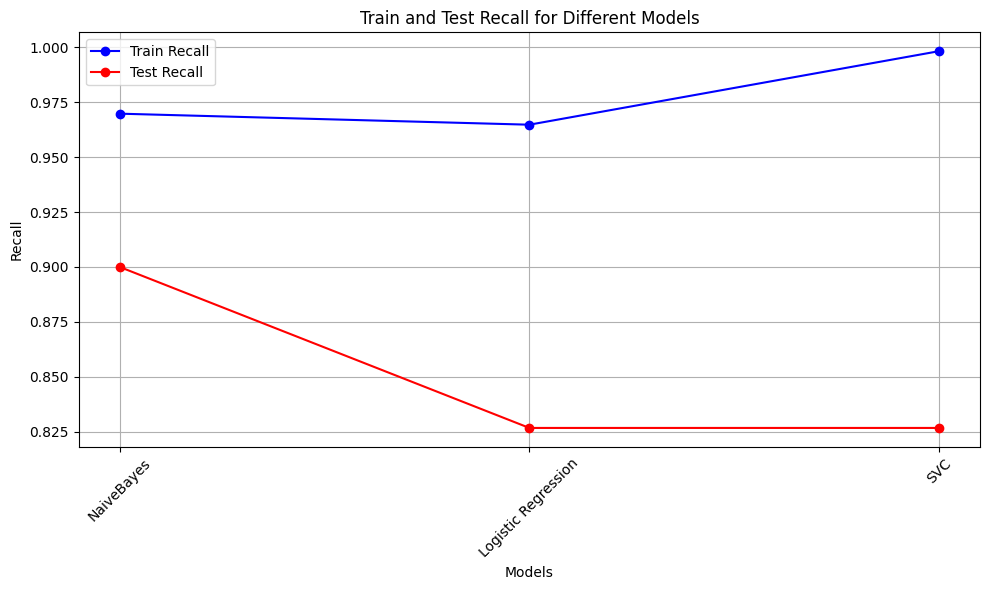

In [37]:
recall_scores_test = []
recall_scores_train = []
model_names = []


for name, model in models.items():


    y_pred = model.predict(X_test)
    y_pred_tr = model.predict(X_train)

    # Calculate and save recall scores
    recall_test = recall_score(y_test, y_pred, average='binary')
    recall_train = recall_score(y_train, y_pred_tr, average='binary')

    recall_scores_test.append(recall_test)
    recall_scores_train.append(recall_train)
    model_names.append(name)


plt.figure(figsize=(10, 6))

plt.plot(model_names, recall_scores_train, marker='o', linestyle='-', color='b', label='Train Recall')
plt.plot(model_names, recall_scores_test, marker='o', linestyle='-', color='r', label='Test Recall')

plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Train and Test Recall for Different Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
